Создание обратной последовательности используя референс.  
Если референс = AATGTGCC, то обратная будет = GGCACATT

In [1]:
from func_for_BioUML import *

reference = read_fasta('reference.fasta')
reference = reverse_complement(reference[0])
write_seq_in_file_with_length('reference_compl.fasta', [reference], 0, 0)



Создание 100 наборов прочтений с помощью simlord для прямого и для обратного референсов с заданными параметрами модели ошибок

In [1]:

for pi in range(100):
            !simlord --read-reference reference.fasta  -n 10 -fl 14502 -pi 0.0456  -pd 0.0188 -ps 0.0321  myreads_{pi}
for pi in range(100):
            !simlord --read-reference reference_compl.fasta  -n 10 -fl 14502 -pi 0.0456  -pd 0.0188 -ps 0.0321  myreads_compl_{pi}



Time for reading/generating the reference: 0:00:00.000106 h
Time for simulation of 10 reads: 0:00:00.065332 h.
Time for reading/generating the reference: 0:00:00.000080 h
Time for simulation of 10 reads: 0:00:00.054323 h.
Time for reading/generating the reference: 0:00:00.000084 h
Time for simulation of 10 reads: 0:00:00.050794 h.
Time for reading/generating the reference: 0:00:00.000084 h
Time for simulation of 10 reads: 0:00:00.054539 h.
Time for reading/generating the reference: 0:00:00.000082 h
Time for simulation of 10 reads: 0:00:00.052880 h.
Time for reading/generating the reference: 0:00:00.000086 h
Time for simulation of 10 reads: 0:00:00.053921 h.
Time for reading/generating the reference: 0:00:00.000087 h
Time for simulation of 10 reads: 0:00:00.051417 h.
Time for reading/generating the reference: 0:00:00.000089 h
Time for simulation of 10 reads: 0:00:00.053026 h.
Time for reading/generating the reference: 0:00:00.000118 h
Time for simulation of 10 reads: 0:00:00.057090 h.
T

Запуск создания 100 консенсусов из 100 разных наборов прочтений

In [3]:
from func_for_BioUML import *

for pi in range(100):
    # Создание прямого консенсуса из прямых прочтений
    run_consensus(f'myreads_{pi}.sam', '/home/divolin/I/pacbio/actual/prog/tests_2', '/home/divolin/I/pacbio/actual/prog/muscle3.8.31_i86linux64')
    # Создание обратного консенсуса из обратных прочтений
    run_consensus_compl(f'myreads_compl_{pi}.sam', '/home/divolin/I/pacbio/actual/prog/tests_2', '/home/divolin/I/pacbio/actual/prog/muscle3.8.31_i86linux64')
    # Создание итогового консенсуса из прямого и обратного консенсусов
    consensus_final('/home/divolin/I/pacbio/actual/prog/muscle3.8.31_i86linux64', f'consensus_{pi}.fastq')

# Создание одного файла со всеми консенсусами и референсом внутри
tmp = read_fasta('reference.fasta')
list_fastq = []
list_fastq.append(tmp[0])
for pi in range(100):
    tmp = read_fastq(f'consensus_{pi}.fastq')
    list_fastq.append(tmp[0])
write_seq_in_file_with_length('all_cons.fasta', list_fastq, 0, 0)

100%|██████████| 726/726 [00:03<00:00, 201.23it/s]


Запуск множественного выравнивания консенсусов с референсом. Штраф за пропуск = -400

In [4]:
!./muscle3.8.31_i86linux64 -gapopen -400 -in 'all_cons.fasta' -out 'all_cons_align.fasta' -quiet

Сортировка консенсусов, чтобы референс вернулся на первую строку. Сортировка производится просто по названию последовательностей, они нумеруются последовательно начиная с 0

In [5]:
list_cons = []
tmp = sort_fasta(f'all_cons_align.fasta')
for rec in tmp:
    list_cons.append(str(rec.seq))
write_seq_in_file_with_length(f'all_cons_align_sorted.fasta', list_cons, 0, 0)

После выравнивания каждая вставка выделилась в отдельный столбец, где есть нуклеотид-вставка, а всё остальное пропуски.  
Тем самым увеличивается длина  множественного выравнивания и статистика считается относительно удлинённого множественного выравнивания

Подсчёт различных статистик

Text(0, 0.5, '% ошибок')

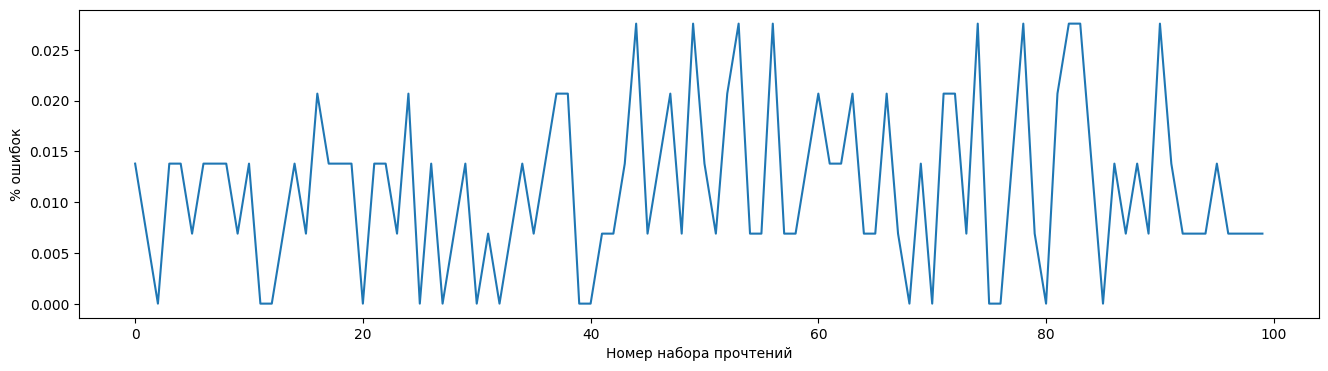

In [6]:
import matplotlib.pyplot as plt
from func_for_BioUML import *

tmp = read_fasta('all_cons_align_sorted.fasta')
reference = read_fasta('reference.fasta')
# list_error_all - список с процентом ошибок в каждом консенсусе, подсчитывается
#  количество ошибок в консенсусе и делится на длину референса и умножается на 100, 
# чтобы перевести в проценты
list_error_all = []
# list_error - список с количеством ошибок в каждом консенсусе
list_error = []
# list_error_position_all - список со списками, в которых перечислены все позиции 
# нуклеотидов каждого консенсуса и если нуклеотид консенсуса совпадает с нуклеотидом
#  референса, то ставится единица, если нет, то ноль
list_error_position_all = []
for i in range(1, len(tmp)):
    tmp2 = 0
    list_error_position = []
    for j in range(len(tmp[0])):
        
        if tmp[0][j] != tmp[i][j]:
            tmp2 += 1
            list_error_position.append(0)
        else:
            list_error_position.append(1)
    list_error.append(tmp2)
    list_error_all.append(tmp2 / len(reference[0]) * 100)
    list_error_position_all.append(list_error_position)

# График, на котором перечислены все консенсусы и % ошибок в них
plt.figure(figsize=(16, 4))
plt.plot(list_error_all)
plt.xlabel('Номер набора прочтений')
plt.ylabel('% ошибок')

Text(0, 0.5, 'Вероятность соответствия')

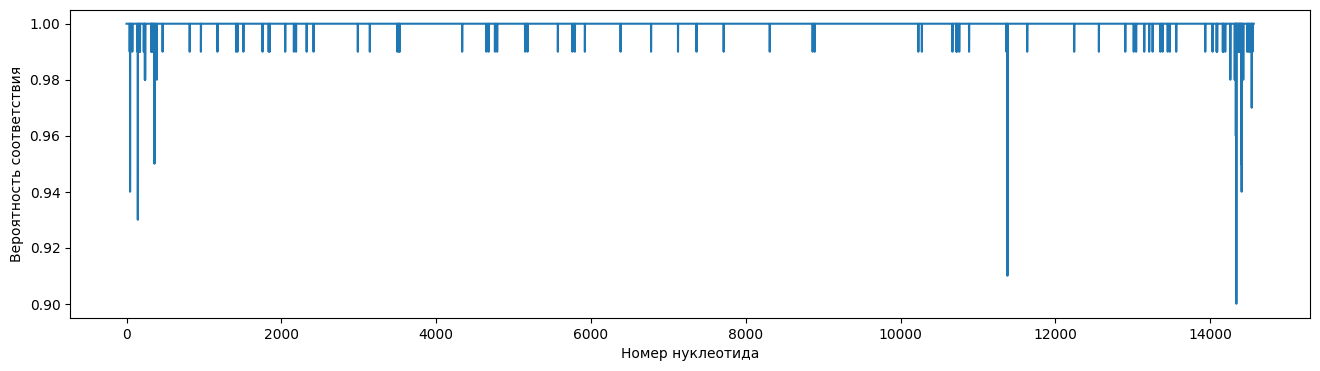

In [7]:
list_prop_error_position = []
for i in range(len(list_error_position_all[0])):
    tmp = 0
    for j in range(len(list_error_position_all)):
        tmp += list_error_position_all[j][i]
    list_prop_error_position.append(tmp / 100)

# График, на котором перечислены все позиции нуклеотидов и средний % совпадения нуклеотида с референсом
plt.figure(figsize=(16,4))
plt.plot(list_prop_error_position)
plt.xlabel('Номер нуклеотида')
plt.ylabel('Вероятность соответствия')

In [8]:
count = 0
for i in list_error:
    count += i
tmp = read_fasta('reference.fasta')
print('Средний процент ошибок в консенсусе =', (count * 100) / (100 * len(tmp[0])))

Средний процент ошибок в консенсусе = 0.011378525618922834
